In [1]:
import pandas as pd
import os
import pyarrow.parquet as pq
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sensor = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
df = pd.read_csv("/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv")
train_meta = pq.ParquetFile('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
it = train_meta.iter_batches()
train_meta = next(it).to_pandas()

# Inspection of sensors with annotated data : Auxiliary.
- Each signals yielded from sensors provide "Auxiliary" information, which represents the quality of the signal.

- This inspection aims to detect sensors with highly interrupted by noise, across all possible train bathces.

In [3]:
def get_batch(batchfile):
    batch1 = pq.ParquetFile(batchfile)
    it = batch1.iter_batches()
    batch1 = next(it).to_pandas()
    return(batch1)

# Appending parquet dataset

In [4]:
path_batch = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'
sensor_info = [get_batch(path_batch+'batch_'+str(i+1)+'.parquet') for i in tqdm(range(len(os.listdir(path_batch))))]

100%|██████████| 660/660 [18:27<00:00,  1.68s/it]


In [5]:
aux_true = []
for s in tqdm(sensor_info):
    aux_true.append(pd.DataFrame(s[s.auxiliary==True][['sensor_id','auxiliary']].value_counts()).sort_index())

100%|██████████| 660/660 [00:07<00:00, 86.25it/s]


# Processing number of Auxiliary==True signals for each sensors

In [6]:
aux_true = pd.concat(aux_true).reset_index().drop('auxiliary',axis=1)
aux_true_result = aux_true.groupby('sensor_id').sum()
aux_true_result.columns = ['Num_Aux_True']

## Looks like sensor id around ~=5000 is quite noisy...

In [7]:
aux_true_result.sort_values('Num_Aux_True')[::-1].head(3)

,Num_Aux_True
sensor_id,
5071,5428
5078,5408
5047,5364


# Distribution of auxiliary==True sensors using standard deviation

Text(0.5, 1.0, 'Distribution of cumulative Auxiliary number per sensors')

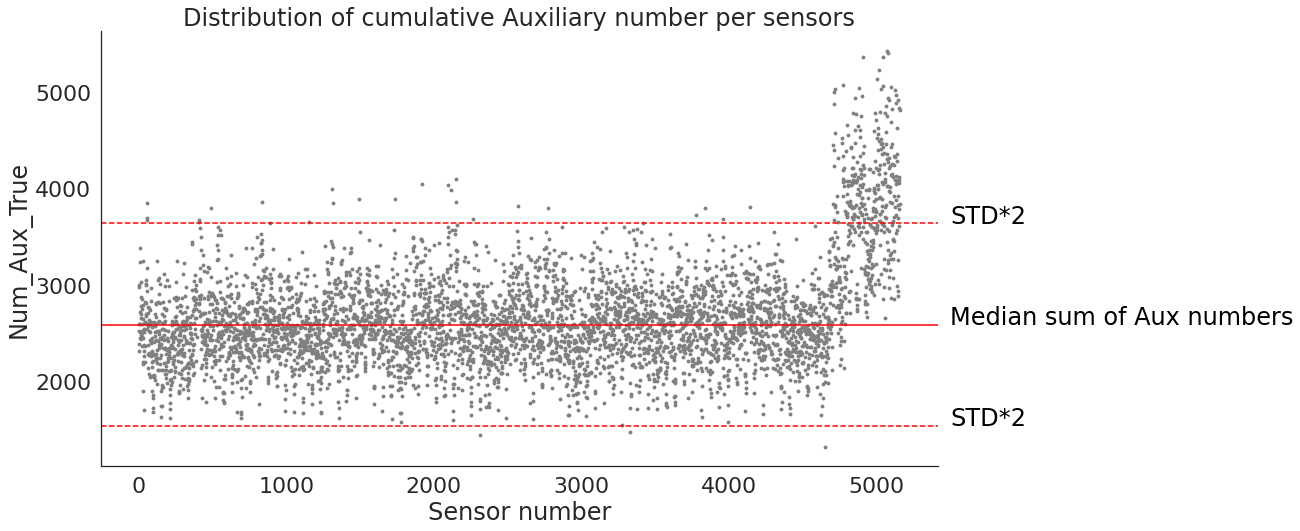

In [8]:
std_t2_p = aux_true_result.Num_Aux_True.median() + 2*aux_true_result.Num_Aux_True.std()
std_t2_m = aux_true_result.Num_Aux_True.median() - 2*aux_true_result.Num_Aux_True.std()


sns.set(font_scale = 2,style = 'white')
plt.figure(figsize = (15,8))
sns.scatterplot(data = aux_true_result,x = aux_true_result.index.tolist(),y = 'Num_Aux_True',linewidth =0,s = 15,color = 'grey')
plt.axhline(aux_true_result.Num_Aux_True.median(),color = 'red')
plt.axhline(std_t2_p,color = 'red',linestyle='--')
plt.axhline(std_t2_m,color = 'red',linestyle='--')

plt.text(5500,aux_true_result.Num_Aux_True.median(),'Median sum of Aux numbers',color = 'black')
plt.text(5500,std_t2_p,'STD*2',color = 'black')
plt.text(5500,std_t2_m,'STD*2',color = 'black')

sns.despine()
plt.xlabel('Sensor number')
plt.title('Distribution of cumulative Auxiliary number per sensors')

# Annotating outlier sensors

In [9]:
sensor_under_std2 = aux_true_result[aux_true_result.Num_Aux_True<std_t2_m].index.tolist()
sensor_over_std2 = aux_true_result[aux_true_result.Num_Aux_True>std_t2_p].index.tolist()
sensor['Outlier_sensors'] = 'Normal'
sensor.loc[sensor.sensor_id.isin(sensor_under_std2), 'Outlier_sensors'] = '< 2*STD'
sensor.loc[sensor.sensor_id.isin(sensor_over_std2), 'Outlier_sensors'] = '> 2*STD'


# Visualize outlier sensors
> From https://www.kaggle.com/code/ridwanultanvir/icecube-extreme-gradient-boosting-supervised

In [10]:
import plotly.express as px
fig = px.scatter_3d(sensor, x='x', y='y', z='z', color='Outlier_sensors', size='sensor_id',
                   title="IceCube Observatory : Visualization of irregular sensors")

fig.show()